In [169]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [170]:
# gencode 25 metadata 
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')

# gencode 35 metadata 
metadata_pc_g35 = pd.read_csv('tmp_res/metadata_pc_g35.txt', sep='\t')

# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

In [171]:
PhyloSET = pd.read_csv('tmp_res/SET1.txt', sep='\t')

RiboSET = pd.read_csv('tmp_res/SET2.txt', sep='\t')

# Buld profiles from 13 studies 

In [172]:
def get_Asite_in_3reading_frames_from_profile_df(profile_df, 
                                                 tr_id, 
                                                 annotation_df):
    
    # get all variables 
    tr_length = annotation_df[annotation_df['tr_id'].str.contains(tr_id)].iloc[0].tr_id_len
    tr_seq = annotation_df[annotation_df['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq
    gene = annotation_df[annotation_df['tr_id'].str.contains(tr_id)].iloc[0].gene
    

    # d = dict with positioons and counts 
    d = dict(zip([int(x) for x in profile_df['Position'].tolist()], [int(x) for x in profile_df['Count'].tolist()]))
    frames = {'Frame_1': {}, 'Frame_2': {}, 'Frame_3': {} }
    for pos, counts in d.items():
        if pos % 3 == 1:
            frames['Frame_1'][pos] = counts
        elif pos % 3 == 2:
            frames['Frame_2'][pos] = counts
        else:
            frames['Frame_3'][pos] = counts
    
    
    # make df with 3 reading frames and save it 
    li1 = []
    li2 = []
    li3 = []
    for i in range(1, tr_length+1):
        if i in frames['Frame_1']:
            li1.append([i, int(frames['Frame_1'][i])])
        else:
            li1.append([i, int(0)])
    df1 = pd.DataFrame(li1, columns = ['Position', 'Frame 1']).sort_values(by='Position')
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_2']:
            li2.append([i, int(frames['Frame_2'][i])])
        else:
            li2.append([i, int(0)])
    df2 = pd.DataFrame(li2, columns = ['Position', 'Frame 2']).sort_values(by='Position')
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_3']:
            li3.append([i, int(frames['Frame_3'][i])])
        else:
            li3.append([i, int(0)])
    df3 = pd.DataFrame(li3, columns = ['Position', 'Frame 3']).sort_values(by='Position')
    
    df_f = df1.merge(df2, on='Position', how='inner').merge(df3, on='Position', how='inner')
    df_f['Sequence'] = list(tr_seq)
    #df_f['Position'] = df_f['Position']
    df_f['rna_seq'] = None
    df_f[['Position', 'Sequence', 'Frame 1', 'Frame 2', 'Frame 3', 'rna_seq']].to_csv('data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id,gene),  index=False)

In [173]:
metadata_pc_g25 = pd.read_csv('/home/alla/make_PhD_great_again/NTE/VERSION_since_May2021/tmp_res/metadata_pc_g25.txt', sep='\t')

metadata_pc_g25_5utr = metadata_pc_g25[metadata_pc_g25['5UTR_start_seq'].notna()]

metadata_pc_g25_5utr['tr_id_len'] = metadata_pc_g25_5utr['transcript_seq'].str.len()

print ('# of transcripts wit 5UTR: ', metadata_pc_g25_5utr.tr_id.nunique())

# of transcripts wit 5UTR:  78873


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Plots 

In [174]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(4, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1]}, sharex=True, sharey=False)

    main_plot = axes[0]
    #cds = axes[1]
    #orfs = axes[1]
    red = axes[1]
    green = axes[2]
    blue = axes[3]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    #orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    #orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #orfs.add_patch(rect)
        
            #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min()-1, f.Position.max(), fraq))       
    blue.set_xticklabels(range(f.Position.min()-1, f.Position.max(), fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])

        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    #plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

146
0


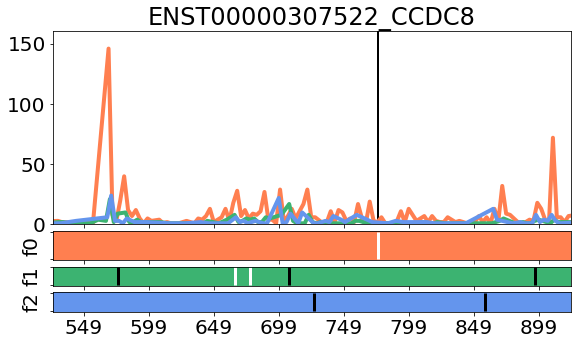

In [175]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'


pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = 'CCDC8_phyloset.png', font1=20, font2=24)

In [176]:
# genes from 2011 paper
genes_42 = 'RASL10B,FGFR1,YPEL2,ENOX2,UFSP1,WDR26,TIAL1,YPEL4,NGF,TRPV6,KCTD11,STARD10,YPEL1,R3HCC1,ZFP62,NHLRC4,EPHX3,C1QL4,TLE3,HDGF,ANKRD42,FAM217B,NFKBID,PTEN,RNF187,METTL23,TMEM8B,VANGL2,FNDC5,C1QL1,CITED1,EIF4G3,HELZ2,CYTH2,NTF3,MFSD4B,C1QL3,KCNN4,IFT46,RASD2,CITED2,C1QL2'.split(',')
genes_17 = 'GTF3A, EIF4G2, SP3, PRPS1L1, TEAD4, TEAD3, CACNG8, OAZ3, TEAD1, DDX17, VEGFA, NR1I2, HCK, WT1, BAG1, NPW, MYC'.split(', ')

In [177]:
ANNOTATED_EXT_FOUND_df_g35_3 = pd.read_csv('tmp_res/ANNOTATED_EXT_FOUND_df_g35_pc_complete_CDS.txt', sep='\t')

print (ANNOTATED_EXT_FOUND_df_g35_3.gene.nunique())

ANNOTATED_EXT_FOUND_df_g35_3[0:2]

24


,tr_id,gene,refseq_id,cds_find,nte_find,biotype,tag
0,ENST00000373471.8,FNDC5,NM_153756.3,0,-1,protein_coding,"non_ATG_start,basic,CCDS"
1,ENST00000479764.6,OAZ3,NM_016178.2,0,-1,protein_coding,"non_canonical_other,non_ATG_start,basic,exp_conf"


# Ann till the 1st AUG

## FNDC5

FNDC5 ENST00000373471
20
1


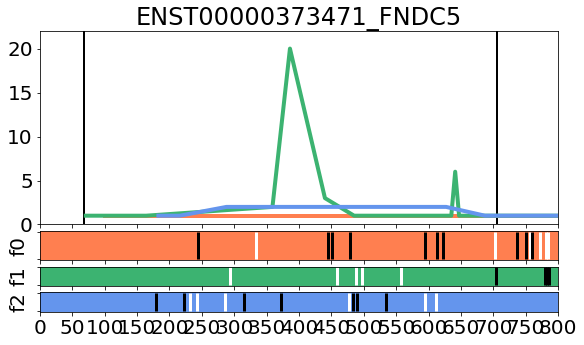

In [178]:
i = 0

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =5, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=(0, 800),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

## OAZ3

OAZ3
22
1


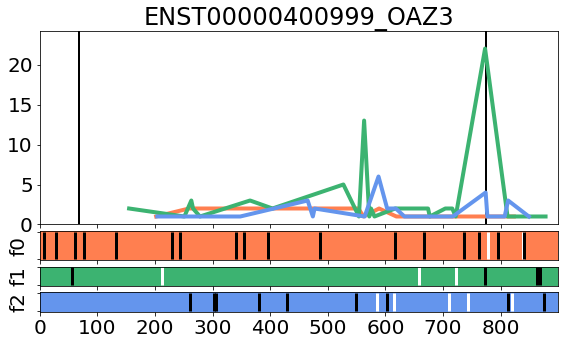

In [179]:
i = 2

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =5, 
                             fraq = 100, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=(0, 900),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# RNF187

RNF187 ENST00000305943
1033
1


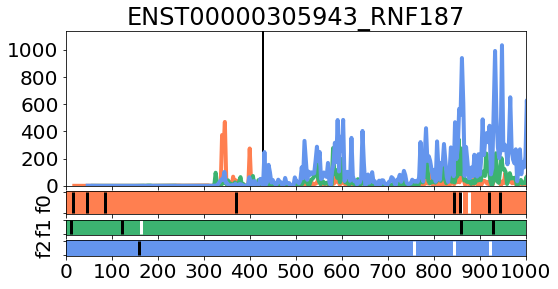

In [180]:
i = 3

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 1001),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# SP3

SP3 ENST00000418194
524
1


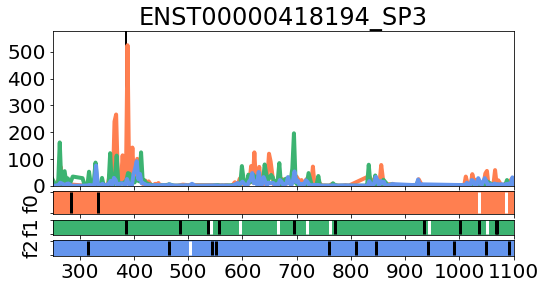

In [181]:
i = 4

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(250, 1100),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# NR1I2

NR1I2 ENST00000393716
1
1


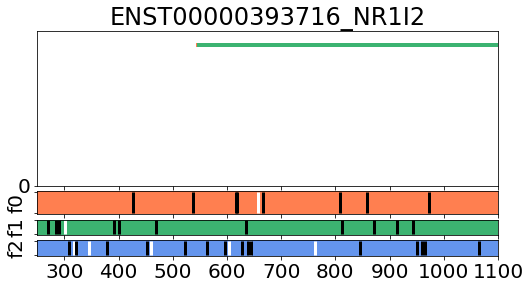

In [182]:
i = 6

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(250, 1100),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

NR1I2 ENST00000466380
1
1


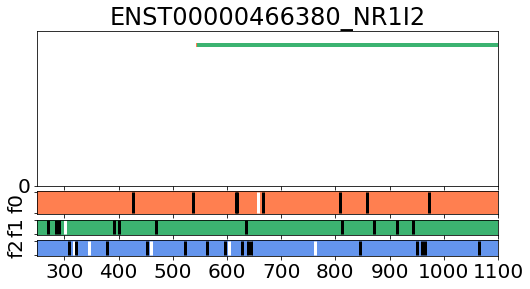

In [183]:
i = 7

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(250, 1100),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# TEAD3

TEAD3 ENST00000338863
906
1


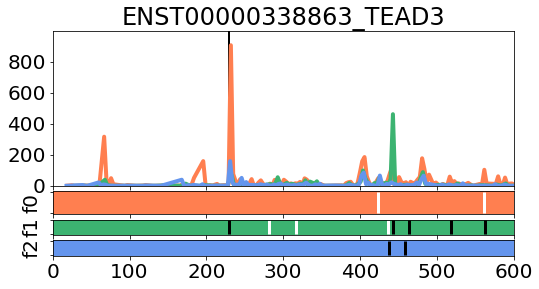

In [154]:
i = 8

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 600),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# VEGFA

VEGFA ENST00000372067
1317
1


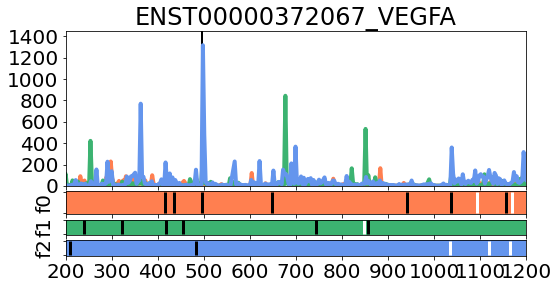

In [79]:
i = 10

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(200, 1200),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# PRPS1L1

PRPS1L1 ENST00000506618
1
1


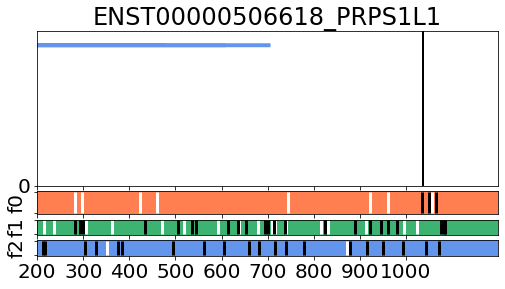

In [88]:
i = 19

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(200, 1200),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# TRPV6

TRPV6 ENST00000359396
3
1


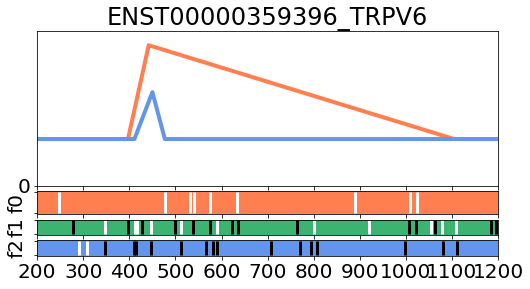

In [89]:
i = 20

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(200, 1200),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# R3HCC1

R3HCC1 ENST00000265806
629
1


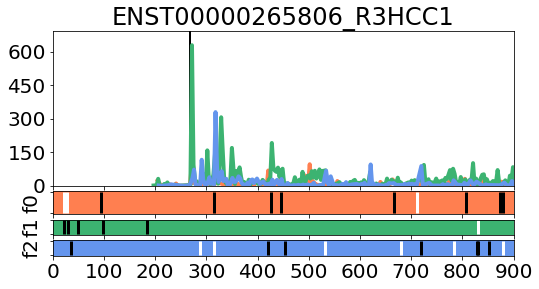

In [93]:
i = 21

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =150, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 900),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# MYC

MYC ENST00000621592
6797
1


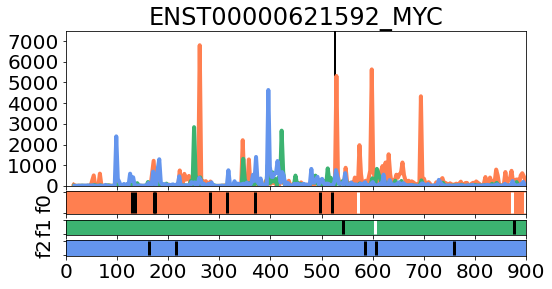

In [96]:
i = 22

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 900),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

In [100]:
ANNOTATED_EXT_FOUND_df_g35_3[ANNOTATED_EXT_FOUND_df_g35_3['gene'] == 'BAG1']

,tr_id,gene,refseq_id,cds_find,nte_find,biotype,tag
23,ENST00000634734.2,BAG1,NM_001172415.2,0,-1,protein_coding,"non_ATG_start,basic,appris_principal_3,CCDS"


In [ ]:
ENST00000634734_BAG1_unamb.csv

BAG1 ENST00000634734
1991
1


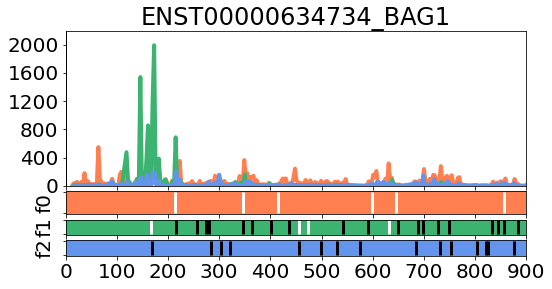

In [104]:
i = 23

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =400, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 900),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# EIF4G2

EIF4G2 ENST00000526148
11286
1


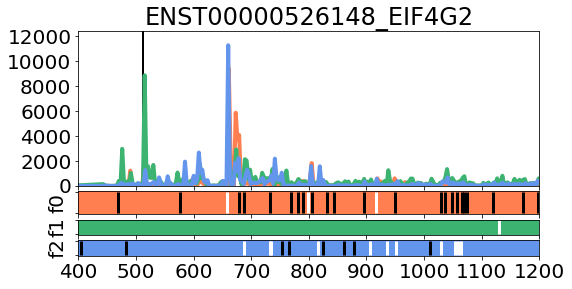

In [110]:
i = 24

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(400, 1200),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# WT1

WT1 ENST00000332351
47
1


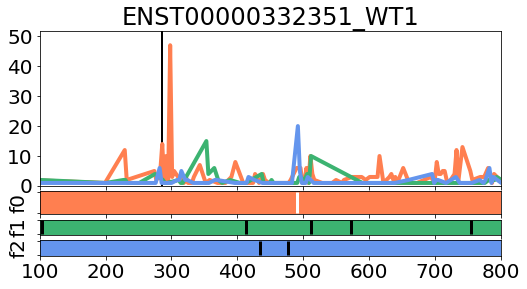

In [119]:
i = 29

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(100, 800),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# TEAD4

TEAD4 ENST00000358409
604
1


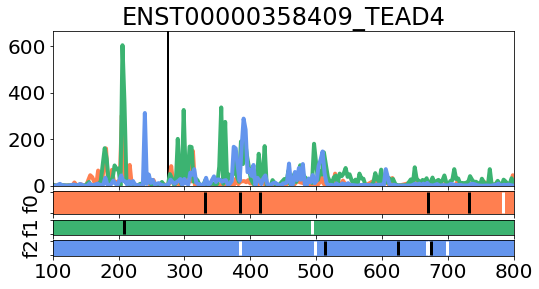

In [123]:
i = 32

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(100, 800),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# GTF3A

GTF3A ENST00000381140
756
1


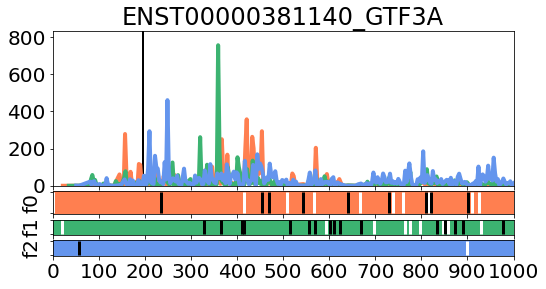

In [127]:
i = 34

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =200, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 1000),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# NPW

In [130]:
ANNOTATED_EXT_FOUND_df_g35_3[ANNOTATED_EXT_FOUND_df_g35_3['gene'] == 'NPW']

# ENST00000473464_NPW_unamb.csv 

,tr_id,gene,refseq_id,cds_find,nte_find,biotype,tag
35,ENST00000566435.3,NPW,NM_001099456.3,0,-1,protein_coding,"non_ATG_start,basic,appris_principal_1,CCDS"


NPW ENST00000566435
4945
1


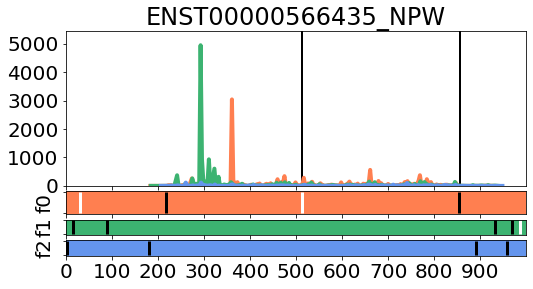

In [135]:
i = 35

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 1000),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

NPW ENST00000473464
281
1


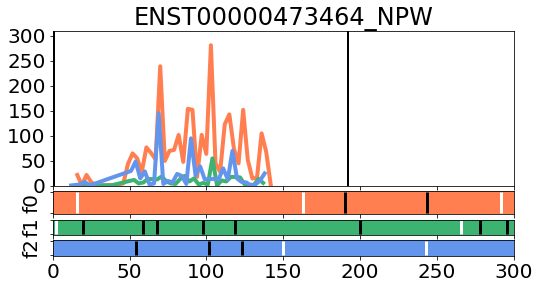

In [141]:
i = 35

gene = 'NPW'

tr_id = 'ENST00000473464'

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 300),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

NPW ENST00000329610
5207
1


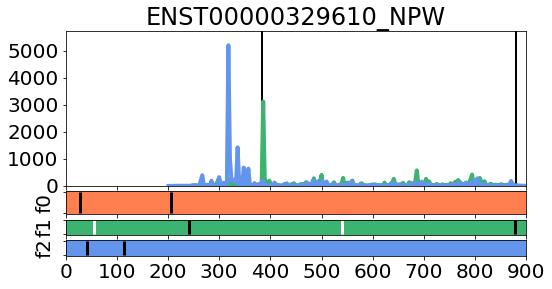

In [145]:
i = 35

gene = 'NPW'

tr_id = 'ENST00000329610'

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 900),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# KCTD11

KCTD11 ENST00000333751
276
1


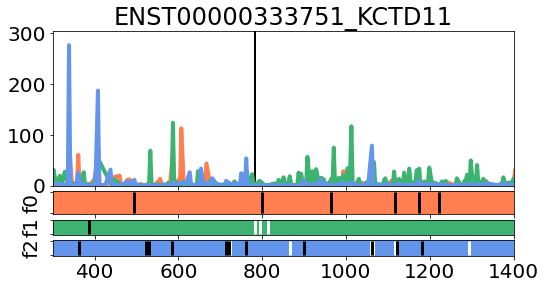

In [212]:
i = 36

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].tr_id.split('.')[0]

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 200, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(300, 1400),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

KCTD11 ENST00000333751
276
1


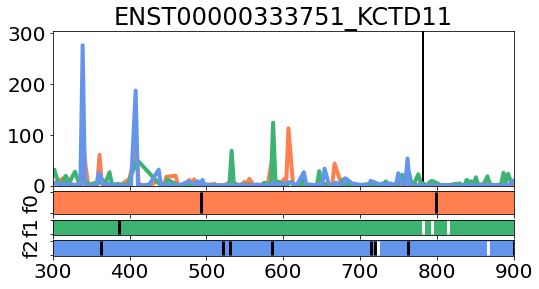

In [160]:
i = 36  # exists in later versions, but not in g25

tr_id = 'ENST00000333751'

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =100, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(300, 900),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

In [156]:
cds_start_pos - 39*3

117

In [158]:
metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains('ENST00000333751')].iloc[0].cds_start_pos

781

In [159]:
781-117

664

# YPEL2

YPEL2 ENST00000585166
93
1


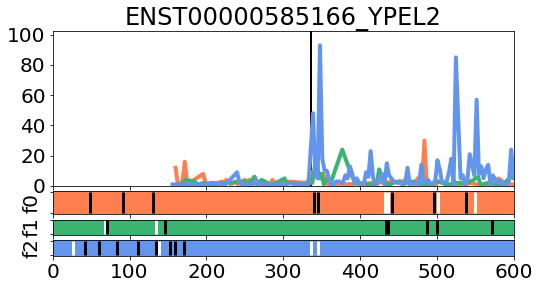

In [191]:
i = 37  # exists in later versions, but not in g25

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = 'ENST00000585166'

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =20, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 600),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

In [188]:
metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains('ENST00000585166')].iloc[0].cds_start_pos - 30*3

245

In [187]:
metadata_pc_g25[metadata_pc_g25['gene'] == 'YPEL2']

,tr_id,gene,gene_tr,transcript_seq,5UTR_start_seq,CDS_start,cds_seq,cds_start_codon,cds_stop_codon,cds_start_pos,cds_stop_pos,utr5_start,utr5_end,record_id
75154,ENST00000312655.8,YPEL2,YPEL2-001,TGGCGGAGACTGTGGCTTTAAGAGCGTGCCGGGAGCCCGAGCCCCA...,TGGCGGAGACTGTGGCTTTAAGAGCGTGCCGGGAGCCCGAGCCCCA...,CCA,ATGGTGAAGATGACAAGATCGAAGACTTTCCAGGCATATCTGCCCT...,ATG,TGA,318,678,0,318,ENST00000312655.8|ENSG00000175155.8|OTTHUMG000...
75155,ENST00000585166.1,YPEL2,YPEL2-002,TTCGGCAGGCAGAGCATCACTACTACATGGAACCAGGACTTTAAAG...,TTCGGCAGGCAGAGCATCACTACTACATGGAACCAGGACTTTAAAG...,CCA,ATGGTGAAGATGACAAGATCGAAGACTTTCCAGGCATATCTGCCCT...,ATG,TGA,335,695,0,335,ENST00000585166.1|ENSG00000175155.8|OTTHUMG000...


# NFKBID

NFKBID ENST00000396901
181
1


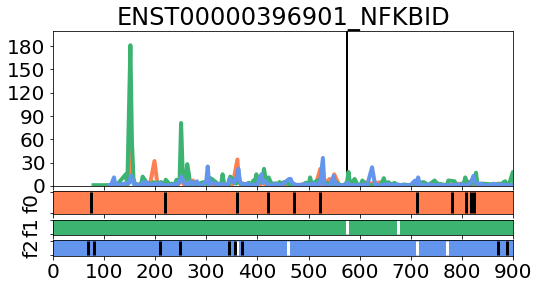

In [195]:
i = 38  # exists in later versions, but not in g25

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = 'ENST00000396901'

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =30, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 900),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

## CACNG8

CACNG8 ENST00000270458
33
1


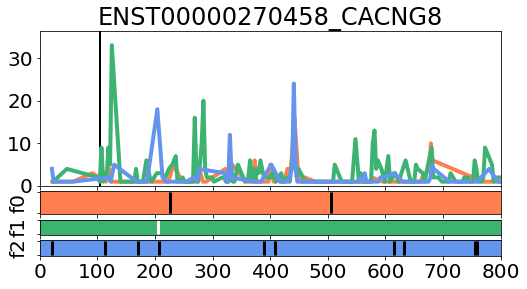

In [200]:
i = 39  # exists in later versions, but not in g25

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = 'ENST00000270458'

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =10, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 800),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)

# HCK

# YPEL1

# DDX17

DDX17 ENST00000403230
2895
1


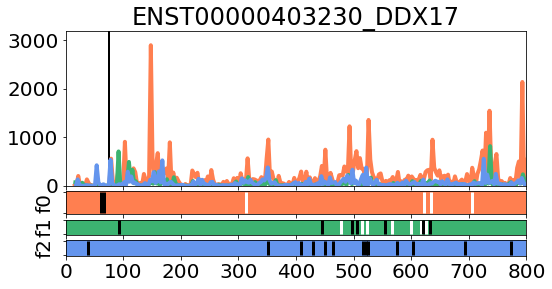

In [209]:
i = 43 # exists in later versions, but not in g25

gene = ANNOTATED_EXT_FOUND_df_g35_3.iloc[i].gene

tr_id = 'ENST00000403230'

print (gene, tr_id)


d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/13studies/profiles_by_reading_frame/%s_%s_unamb.csv' % (tr_id, gene), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            #predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000, 
                             fraq = 100, 
                             cds = False,
                           figsize=(8, 4),
                             linew = 4, 
                           xlims=(0, 800),
                            zeros=False)

trips_full2(d1, name = 'test.png', font1=20, font2=24)